<a href="https://colab.research.google.com/github/shashidhar078/MyPandas/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [3]:
# Step 2: Load the dataset
df = pd.read_csv("/content/HousingData.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [4]:
# Step 3: Data exploration
print(df.info())
print(df.describe())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Rename target column if needed
if 'MEDV' not in df.columns:
    df.rename(columns={df.columns[-1]: 'MEDV'}, inplace=True)

# Features and target
X = df.drop('MEDV', axis=1)
y = df['MEDV']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  486.000000  486.000000  486.000000  486.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695   

In [5]:
# Step 4: Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print("Original shape:", X.shape, "| After PCA:", X_pca.shape)


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [9]:
# Step 4.1: Impute missing values
from sklearn.impute import SimpleImputer

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [10]:
# Step 4.2: Feature scaling and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print("Original shape:", X.shape, "| After PCA:", X_pca.shape)

Original shape: (506, 13) | After PCA: (506, 10)


In [11]:
# Step 5: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [12]:
# Step 6: Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror')
}

# Evaluate base models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append([name, rmse, r2])

results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R2_Score'])
print(results_df)


               Model      RMSE  R2_Score
0  Linear Regression  5.405080  0.601618
1   Ridge Regression  5.402230  0.602038
2      Decision Tree  4.894244  0.673362
3      Random Forest  4.198452  0.759633
4            XGBoost  4.490813  0.724992


In [13]:
# Step 7: GridSearchCV tuning for key models

# Decision Tree
dt_params = {'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 4, 6]}
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='r2')
grid_dt.fit(X_train, y_train)
print("Best DT params:", grid_dt.best_params_)

# Random Forest
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [5, 7, 9], 'min_samples_leaf': [1, 2, 4]}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='r2')
grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)

# XGBoost
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}
grid_xgb = GridSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror'), xgb_params, cv=5, scoring='r2')
grid_xgb.fit(X_train, y_train)
print("Best XGB params:", grid_xgb.best_params_)


Best DT params: {'max_depth': 7, 'min_samples_split': 2}
Best RF params: {'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 200}
Best XGB params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [14]:
# Step 8: Evaluate tuned models
tuned_models = {
    "Decision Tree (Tuned)": grid_dt.best_estimator_,
    "Random Forest (Tuned)": grid_rf.best_estimator_,
    "XGBoost (Tuned)": grid_xgb.best_estimator_
}

tuned_results = []
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    tuned_results.append([name, rmse, r2])

tuned_df = pd.DataFrame(tuned_results, columns=['Model', 'RMSE', 'R2_Score'])
print("\nTuned Model Performance:\n", tuned_df)



Tuned Model Performance:
                    Model      RMSE  R2_Score
0  Decision Tree (Tuned)  5.001135  0.658938
1  Random Forest (Tuned)  4.197140  0.759784
2        XGBoost (Tuned)  4.096922  0.771118


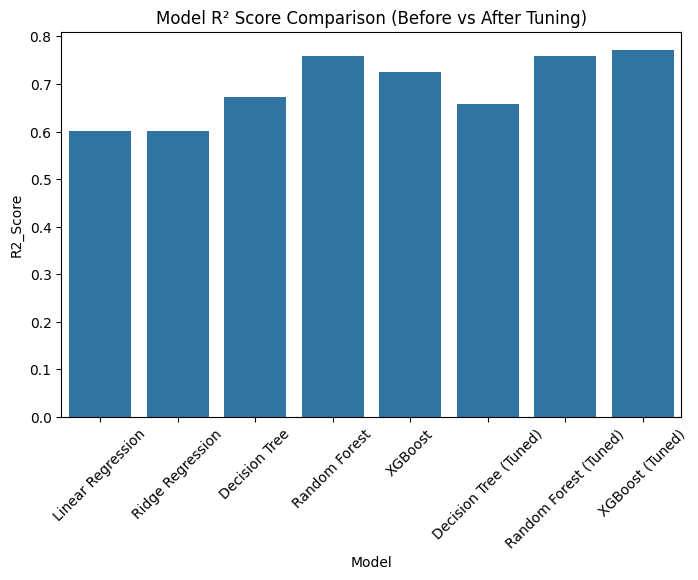

In [15]:
# Combine results
comparison_df = pd.concat([results_df, tuned_df], ignore_index=True)
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='R2_Score', data=comparison_df)
plt.title("Model R² Score Comparison (Before vs After Tuning)")
plt.xticks(rotation=45)
plt.show()
